In [191]:
import os
import pandas as pd
import csv
import math
import numpy as np
from ipywidgets import Dropdown
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.ticker import PercentFormatter

In [192]:
'''folder_path = 'SaliencyData/Task1'

def load_data(file):
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path, delimiter=';', usecols=['GazeTime', 'Region', 'Target', 'PosX', 'PosY', 'PosZ', 'PlayerPosX', 'PlayerPosY', 'PlayerPosZ', 'LightIntensity', 'Velocity'])
    data = data[~((data['PosX'] == 0) & (data['PosY'] == 0) & (data['PosZ'] == 0))

    if len(data) <= 1:  # The data contains only a header
        return None

    # Get the unique regions
    regions = data['Region'].unique()

    # Skip the first region
    for region in regions[1:]:
        # Get the index of the first row of the current region
        first_row_index = data[data['Region'] == region].index[0]
        # Drop the first row of the current region
        data = data.drop(first_row_index)

    # Normalize position data using Min-Max normalization
    pos_columns = ['PosX', 'PosY', 'PosZ', 'PlayerPosX', 'PlayerPosY', 'PlayerPosZ', 'LightIntensity', 'Velocity']
    for column in pos_columns:
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

    return data

# Create a list to store the dataframes
dataframes = [df for df in (load_data(file) for file in os.listdir(folder_path) if file.endswith('.csv')) if df is not None]
os.listdir(folder_path)
dataframes[0]'''

"folder_path = 'SaliencyData/Task1'\n\ndef load_data(file):\n    file_path = os.path.join(folder_path, file)\n    data = pd.read_csv(file_path, delimiter=';', usecols=['GazeTime', 'Region', 'Target', 'PosX', 'PosY', 'PosZ', 'PlayerPosX', 'PlayerPosY', 'PlayerPosZ', 'LightIntensity', 'Velocity'])\n    data = data[~((data['PosX'] == 0) & (data['PosY'] == 0) & (data['PosZ'] == 0))\n\n    if len(data) <= 1:  # The data contains only a header\n        return None\n\n    # Get the unique regions\n    regions = data['Region'].unique()\n\n    # Skip the first region\n    for region in regions[1:]:\n        # Get the index of the first row of the current region\n        first_row_index = data[data['Region'] == region].index[0]\n        # Drop the first row of the current region\n        data = data.drop(first_row_index)\n\n    # Normalize position data using Min-Max normalization\n    pos_columns = ['PosX', 'PosY', 'PosZ', 'PlayerPosX', 'PlayerPosY', 'PlayerPosZ', 'LightIntensity', 'Velocity']\

In [193]:
def load_data(file):
    file_path = os.path.join(folder_path, file)
    data = pd.read_csv(file_path, delimiter=';', usecols=['GazeTime', 'Region', 'Target', 'PosX', 'PosY', 'PosZ', 'PlayerPosX', 'PlayerPosY', 'PlayerPosZ', 'LightIntensity', 'Velocity'])
    data = data[~((data['PosX'] == 0) & (data['PosY'] == 0) & (data['PosZ'] == 0))]

    if len(data) <= 1:  # The data contains only a header
        return None

    # Normalize position data using Min-Max normalization
    pos_columns = ['PosX', 'PosY', 'PosZ', 'PlayerPosX', 'PlayerPosY', 'PlayerPosZ', 'LightIntensity', 'Velocity']
    for column in pos_columns:
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

    return data

folder_path = 'SaliencyData/Task1'

# List directory and sort files by their numerical value after '_'
files = sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[1].split('.csv')[0]))

# Create a list to store the dataframes
dataframes = [df for df in (load_data(file) for file in files if file.endswith('.csv')) if df is not None]


In [194]:
def correct_regions(df):
    # Define valid targets for each region
    valid_targets = {
        1: ['Size(Min)', 'Size(Low)', 'Size(Mid)', 'Size(Max)','None'],
        2: ['Transparency(Min)', 'Transparency(Low)', 'Transparency(Mid)', 'Transparency(Max)','None'],
        3: ['Red', 'White', 'Black', 'Blue','None']
    }
    
    # Define a function to find the correct region for a given target
    def find_correct_region(row):
        if row['Target'] == 'None':
            return row['Region']  # Keep the current region if the target is 'None'
        for region, targets in valid_targets.items():
            if row['Target'] in targets:
                return region
        return row['Region']  # Keep the current region if the target does not belong to any defined region

    # Apply the function to each row in the DataFrame
    df['Corrected_Region'] = df.apply(find_correct_region, axis=1)
    # Replace 'Region' column with 'Corrected_Region', then drop 'Corrected_Region'
    df['Region'] = df['Corrected_Region']
    df.drop('Corrected_Region', axis=1, inplace=True)
    
    return df

# Apply the function to each DataFrame in your list
dataframes = [correct_regions(df) for df in dataframes]


In [195]:
def target_counts(df):
    # Filter out rows where Target is 'None'
    df_filtered = df[df['Target'] != 'None']
    # Count the number of times each 'Target' was looked at
    target_counts = df_filtered['Target'].value_counts().reset_index()
    target_counts.columns = ['Target', 'Count']
    return target_counts

# Use the target_counts function on each DataFrame in your list
all_target_counts = pd.concat([target_counts(df) for df in dataframes])

# Sum the counts for each 'Target' across all DataFrames
total_target_counts = all_target_counts.groupby('Target').sum().reset_index()

print(total_target_counts)


               Target  Count
0               Black     35
1                Blue     14
2                 Red     27
3           Size(Low)     20
4           Size(Max)    109
5           Size(Mid)     35
6           Size(Min)     18
7   Transparency(Low)     35
8   Transparency(Max)     40
9   Transparency(Mid)     36
10  Transparency(Min)     31
11              White     27


In [196]:
def ProximtyVsGazeTime(df):

    # Calculate the Euclidean distance between the object and player positions
    df['Proximity'] = np.sqrt((df['PosX'] - df['PlayerPosX'])**2 + (df['PosY'] - df['PlayerPosY'])**2 + (df['PosZ'] - df['PlayerPosZ'])**2)

    # Create a scatter plot for GazeTime vs Proximity
    plt.figure(figsize=(10, 5))
    plt.scatter(df['Proximity'], df['GazeTime'])
    plt.title('GazeTime vs Proximity')
    plt.xlabel('Proximity')
    plt.ylabel('GazeTime')
    plt.show()

    # Calculate correlation between GazeTime and Proximity
    correlation, _ = pearsonr(df['GazeTime'], df['Proximity'])
    print('Pearson correlation: %.3f' % correlation)

    



In [197]:
def sum(arr):
    ret = 0
    for i in arr:
        ret += i
    return ret

def PercFixInside(dataframe):
    def Compute(region, interest):
        ret = pd.DataFrame()
        target_names = dataframe[dataframe['Region'] == region]['Target'].unique()
        grouped_data = dataframe[dataframe['Region'] == region].groupby('Target')
        gaze = [0] * len(target_names)  # Initialize list with zeros
        perc = [0] * len(target_names)
        ret['Target'] = target_names
        
        for j, target in enumerate(target_names):
            gaze[j] = grouped_data.get_group(target)[interest].sum()
        tot = sum(gaze)

        for i, g in enumerate(gaze):
            perc[i] = (g / tot) * 100 if tot > 0 else 0

        ret['GazeTime'] = gaze
        ret['Percentage'] = perc
        return ret

    regions = dataframe['Region'].unique()

    # Initialize a list to store the DataFrames for each region
    results = []

    for region in regions:
        newdata = Compute(region, 'GazeTime')
        newdata['Region'] = region  # Add a column for the region
        results.append(newdata)

    # Concatenate all the result DataFrames into one
    final_df = pd.concat(results, ignore_index=True)

    return final_df

PercFixInside(dataframes[10])

,Target,GazeTime,Percentage,Region
0,Size(Max),0.083910,4.270790,1
1,None,1.532658,78.008097,1
2,Size(Mid),0.348174,17.721113,1
3,Transparency(Min),0.097412,5.033351,2
4,None,1.629213,84.182573,2
5,Transparency(Max),0.208708,10.784076,2
6,None,1.740877,100.000000,3


In [198]:
def NFix(dataframe, threshold, ShowPercentage = False):
    if(threshold < 0):
        threshold = abs(threshold)
    nfix = {}  # Initialize the NFix counter as a dictionary
    counter = {}  # Initialize the counter as a dictionary

    for _, row in dataframe.iterrows():
        region = row['Region']
        target = row['Target']
        if region not in counter:
            counter[region] = {}
            nfix[region] = {}
        if target not in counter[region]:
            counter[region][target] = 0
            nfix[region][target] = 0

        counter[region][target] += 1
        gaze_time_new = float(row['GazeTime'])  # Get the Gaze Time

        # Check if a fixation occurred by comparing the gaze time with the threshold
        if gaze_time_new > threshold:
            nfix[region][target] += 1  # Increment the NFix counter for the target

    if ShowPercentage:
        for region in nfix:
            for target in nfix[region]:
                nfix[region][target] = (nfix[region][target] / counter[region][target]) * 100 if counter[region][target] > 0 else 0

    # Convert nested dictionary to DataFrame
    nfix_df = pd.DataFrame([(reg, tar, val) for reg, tar_val in nfix.items() for tar, val in tar_val.items()], 
                           columns=['Region', 'Target', 'NFix'])

    return nfix_df


In [199]:
NFix(dataframes[0], 0.15, ShowPercentage = False)

,Region,Target,NFix
0,1,Size(Max),4
1,1,None,0
2,2,None,5
3,2,Transparency(Min),3
4,2,Transparency(Low),1
5,3,None,0


In [200]:
def ConvergTime(dataframe):
    # Group the data by region and then by target
    dataframe = dataframe[dataframe['Target'] != 'None']
    grouped_data = dataframe.groupby(['Region', 'Target'])

    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=['Region', 'Target', 'ConvergenceTime'])

    # Iterate over each group (region and target)
    for (region, target), group in grouped_data:
        # Calculate the average gaze time for the current group (target within the region)
        avg_gaze_time = group['GazeTime'].mean()
        
        # Append the result to the results DataFrame
        results = pd.concat([results, pd.DataFrame({'Region': [region], 'Target': [target], 'ConvergenceTime': [avg_gaze_time]})], ignore_index=True)

    return results

ConvergTime(dataframes[0])

,Region,Target,ConvergenceTime
0,1,Size(Max),0.176729
1,2,Transparency(Low),0.645612
2,2,Transparency(Min),0.199088


In [201]:
def calculate_proximity(df):
    # Calculate the Euclidean distance
    df['Proximity'] = np.sqrt((df['PosX'] - df['PlayerPosX'])**2 + 
                              (df['PosY'] - df['PlayerPosY'])**2 + 
                              (df['PosZ'] - df['PlayerPosZ'])**2)
    # Remove rows with 'None' Target
    df = df[df['Target'] != 'None']
    # Group by 'Target' and 'Region', and calculate mean distance
    df = df.groupby(['Region', 'Target'])['Proximity'].mean().reset_index()
    return df


In [202]:
calculate_proximity(dataframes[10])

,Region,Target,Proximity
0,1,Size(Max),0.915822
1,1,Size(Mid),0.803662
2,2,Transparency(Max),1.144654
3,2,Transparency(Min),0.989266


In [203]:
# Step 1: Apply PercFixInside to each DataFrame in dataframes and accumulate the results


perc_results = [PercFixInside(df) for df in dataframes]

# Step 2: Concatenate the resulting DataFrames into one
all_perc = pd.concat(perc_results)

# Step 3: Group by 'Region' and 'Target' and calculate the mean
avg_perc = all_perc.groupby(['Region', 'Target']).mean().reset_index()

# This will now be a DataFrame with average 'GazeTime' and 'Percentage' for each 'Target' in each 'Region'
for i,j in enumerate(avg_perc['Percentage']):
    #print(str(i)+" : "+ str(j))
    avg_perc.loc[2,i] = j/len(dataframes)
avg_perc

,Region,Target,GazeTime,Percentage,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,None,1.668820,59.126450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Size(Low),0.401264,13.367713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Size(Max),1.119697,43.774804,1.739013,0.393168,1.287494,0.582374,0.551953,1.920918,0.687865,0.433932,0.609737,0.451415,0.463021,0.74552,1.786566,0.693327,0.989547
3,1,Size(Mid),0.635425,19.800707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Size(Min),0.580374,18.766399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,None,1.544874,65.311202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,Transparency(Low),0.759639,23.387400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2,Transparency(Max),0.412129,14.753680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Transparency(Mid),0.484576,20.731059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,Transparency(Min),0.399621,15.348104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
# Step 1: Apply PercFixInside to each DataFrame in dataframes and accumulate the results
perc_results = [PercFixInside(df) for df in dataframes]

# Step 2: Concatenate the resulting DataFrames into one
all_perc = pd.concat(perc_results)

# Step 3: Group by 'Region' and 'Target' and calculate the sum of GazeTime
total_gaze = all_perc.groupby(['Region', 'Target'])['GazeTime'].sum().reset_index()

# Step 4: Calculate the total gaze time in each region
total_gaze_region = total_gaze.groupby('Region')['GazeTime'].sum()

# Step 5: Calculate the percentage of gaze time that each target represents in its region
total_gaze['Percentage'] = total_gaze.apply(lambda row: (row['GazeTime'] / total_gaze_region[row['Region']]) * 100, axis=1)

# This will now be a DataFrame with total 'GazeTime' and 'Percentage' for each 'Target' in each 'Region'
total_gaze = total_gaze[total_gaze['Target'] != 'None']
total_gaze

,Region,Target,GazeTime,Percentage
1,1,Size(Low),4.012639,4.214053
2,1,Size(Max),25.753029,27.045701
3,1,Size(Mid),10.166795,10.677117
4,1,Size(Min),5.223366,5.485552
6,2,Transparency(Low),12.913859,15.570127
7,2,Transparency(Max),6.181934,7.453504
8,2,Transparency(Mid),7.268633,8.763727
9,2,Transparency(Min),5.594700,6.745481
10,3,Black,6.961954,8.112254
11,3,Blue,6.491211,7.563732


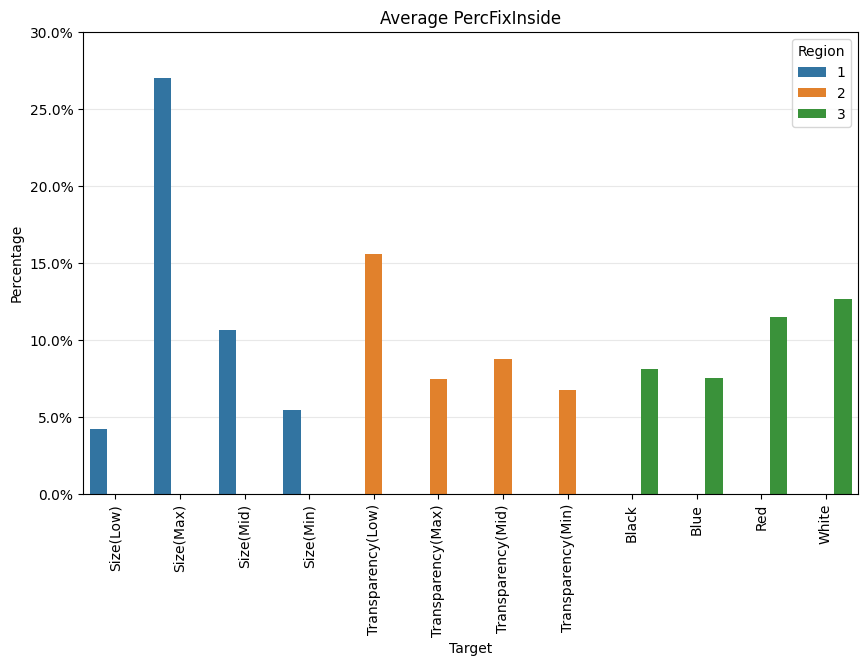

In [205]:
plt.figure(figsize=(10, 6))

# Set grid
ax = plt.gca()
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_axisbelow(True)

# Plotting
ax = sns.barplot(x='Target', y='Percentage', hue='Region', data=total_gaze, zorder=2)

plt.title('Average PercFixInside')
plt.xticks(rotation=90)  # Rotate x-axis labels if they overlap

# Increase the range of y-axis
plt.ylim(0, 30)

# Add '%' symbol to y-axis labels
ax.yaxis.set_major_formatter(PercentFormatter())

plt.show()


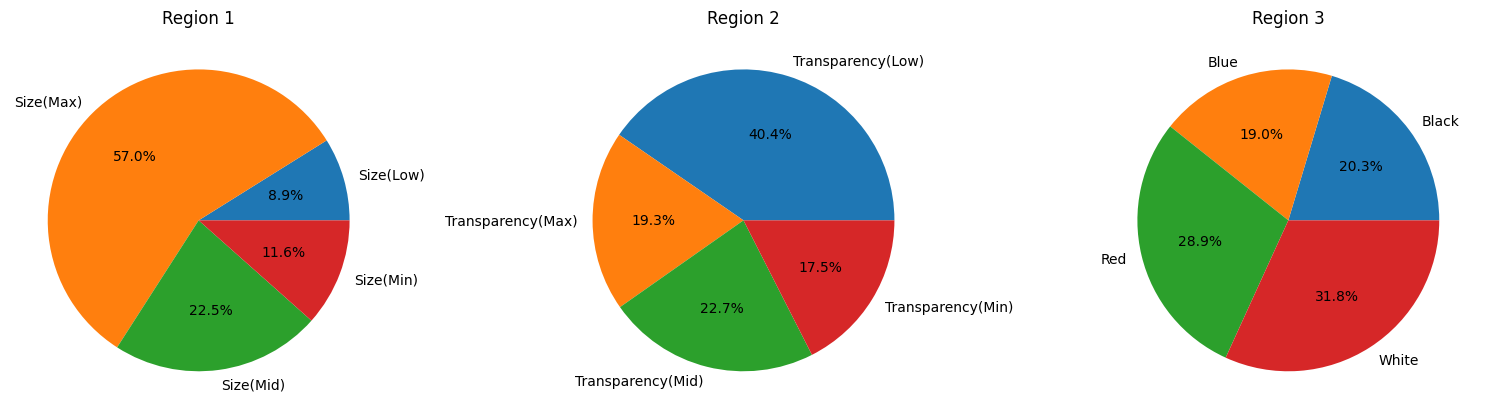

In [206]:
plt.figure(figsize=(15, 5))

for region in total_gaze['Region'].unique():
    plt.subplot(1, 3, region)

    region_data = total_gaze[total_gaze['Region'] == region]
    region_data_grouped = region_data.groupby('Target')['Percentage'].sum()

    plt.pie(region_data_grouped, labels=region_data_grouped.index, autopct='%1.1f%%')
    plt.title(f'Region {region}')

plt.tight_layout()
plt.show()


In [207]:
# Step 1: Apply NFix to each DataFrame in dataframes and accumulate the results
nfix_results = [NFix(df, 0.15, False) for df in dataframes]

# Step 2: Concatenate the resulting DataFrames into one
all_nfix = pd.concat(nfix_results)

# Step 3: Group by 'Region' and 'Target' and calculate the mean
avg_nfix = all_nfix.groupby(['Region', 'Target']).mean().reset_index()

# This will now be a DataFrame with average 'Count' and 'Percentage' for each 'Target' in each 'Region'
avg_nfix = avg_nfix[avg_nfix['Target'] != 'None']

avg_nfix

,Region,Target,NFix
1,1,Size(Low),0.900000
2,1,Size(Max),2.043478
3,1,Size(Mid),0.937500
4,1,Size(Min),1.222222
6,2,Transparency(Low),1.235294
7,2,Transparency(Max),0.733333
8,2,Transparency(Mid),1.000000
9,2,Transparency(Min),0.857143
10,3,Black,0.937500
11,3,Blue,1.857143


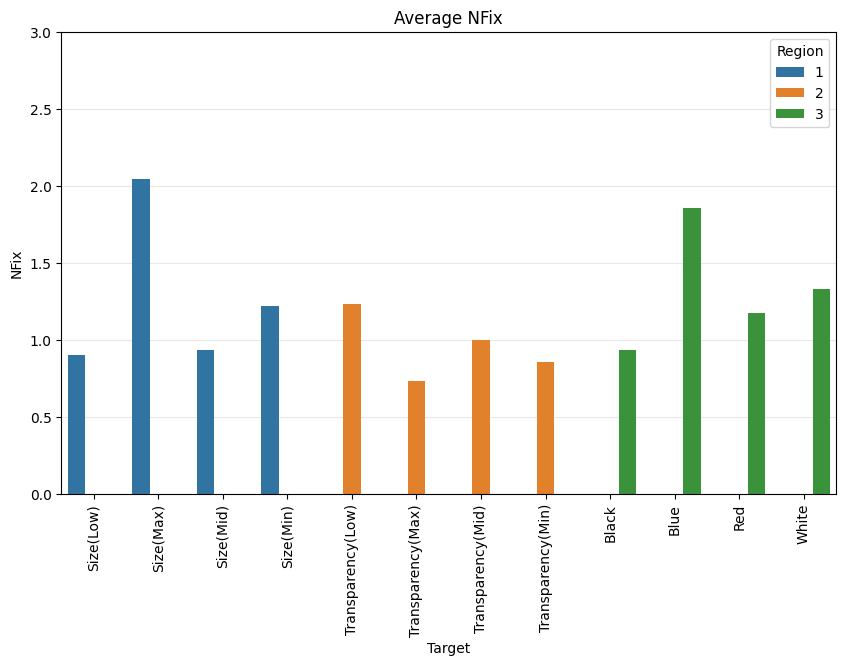

In [208]:
plt.figure(figsize=(10, 6))

# Set grid
ax = plt.gca()
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_axisbelow(True)

# Plotting
ax = sns.barplot(x='Target', y='NFix', hue='Region', data=avg_nfix, zorder=2)

plt.title('Average NFix')
plt.xticks(rotation=90)  # Rotate x-axis labels if they overlap

# Increase the range of y-axis
plt.ylim(0, 3)


plt.show()


In [209]:
def overall_average_distance(dataframes):
    # Create a list to store the distance dataframes
    distance_dfs = []

    # Loop through each dataframe in dataframes
    for df in dataframes:
        # Calculate the distance for each Target in the dataframe
        distance_df = calculate_proximity(df)
        # Append the resulting dataframe to the list
        distance_dfs.append(distance_df)

    # Concatenate all distance dataframes into a single dataframe
    all_data = pd.concat(distance_dfs)

    # Group by Target and Region and calculate the average distance
    all_data = all_data.groupby(['Region', 'Target'])['Proximity'].mean().reset_index()

    return all_data

# usage
overall_avg_distances = overall_average_distance(dataframes)
overall_avg_distances

,Region,Target,Proximity
0,1,Size(Low),0.897515
1,1,Size(Max),0.874892
2,1,Size(Mid),0.926460
3,1,Size(Min),0.889102
4,2,Transparency(Low),0.770988
5,2,Transparency(Max),0.839089
6,2,Transparency(Mid),0.772763
7,2,Transparency(Min),0.633697
8,3,Black,1.030351
9,3,Blue,0.945424


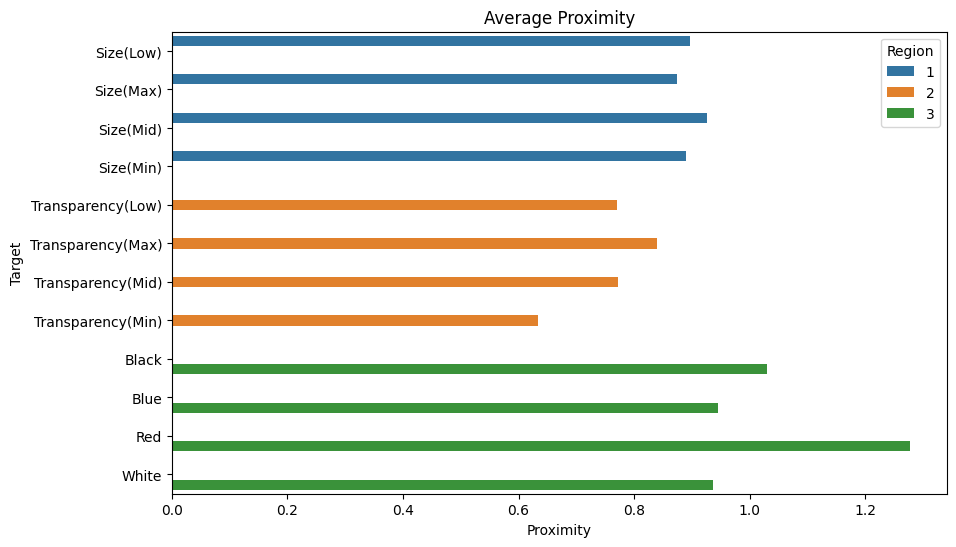

In [210]:
# Horizontal Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Proximity', y='Target', hue='Region', data=overall_avg_distances, orient='h')
plt.title('Average Proximity')
plt.show()



In [211]:
def overall_average_convergence_time(dataframes):
    # Create a list to store the convergence time dataframes
    convergence_time_dfs = []

    # Loop through each dataframe in dataframes
    for df in dataframes:
        # Calculate the convergence time for each 'Region' and 'Target' in the dataframe
        convergence_time_df = ConvergTime(df)
        # Append the resulting dataframe to the list
        convergence_time_dfs.append(convergence_time_df)

    # Concatenate all convergence time dataframes into a single dataframe
    all_data = pd.concat(convergence_time_dfs)

    # Group by 'Region' and 'Target' and calculate the average convergence time
    all_data = all_data.groupby(['Region', 'Target'])['ConvergenceTime'].mean().reset_index()

    return all_data

# usage
overall_avg_convergence_times = overall_average_convergence_time(dataframes)

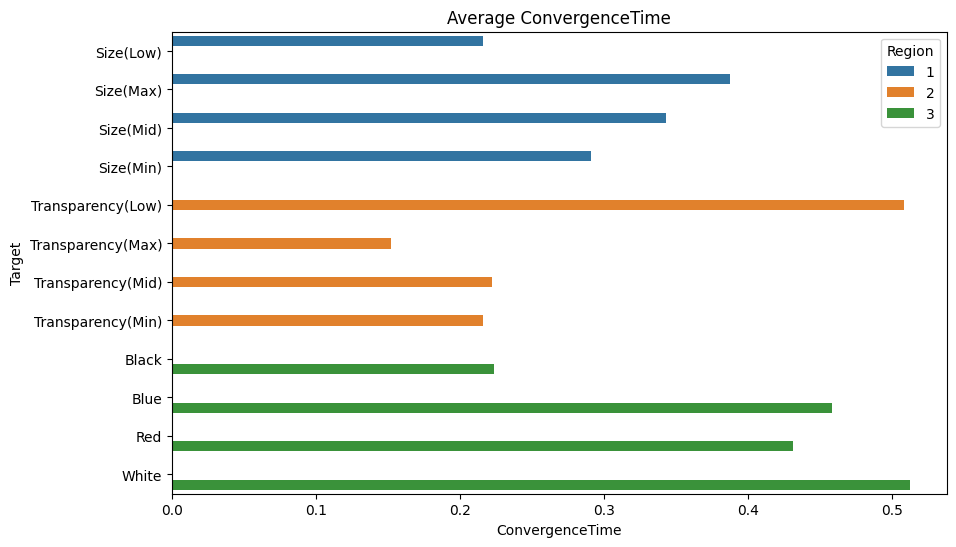

In [212]:
# Horizontal Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='ConvergenceTime', y='Target', hue='Region', data=overall_avg_convergence_times, orient='h')
plt.title('Average ConvergenceTime')
plt.show()



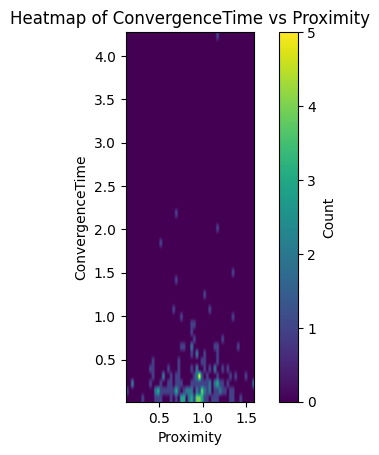

In [213]:
# Initialize empty lists to store the results
proxs = []
conv_times = []

# Iterate over the list of dataframes
for df in dataframes:
    # Apply your ConvergTime and calculate_proximity functions
    conv_time_df = ConvergTime(df)
    prox_df = calculate_proximity(df)
    
    # Merge the results on the 'Target' column
    merged_df = pd.merge(conv_time_df, prox_df, on='Target')
    
    # Append the 'ConvergenceTime' and 'Proximity' columns to the lists
    conv_times.extend(merged_df['ConvergenceTime'].tolist())
    proxs.extend(merged_df['Proximity'].tolist())

# Create a 2D histogram from the results
heatmap, xedges, yedges = np.histogram2d(proxs, conv_times, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot the heatmap
plt.clf()
plt.title('Heatmap of ConvergenceTime vs Proximity')
plt.xlabel('Proximity')
plt.ylabel('ConvergenceTime')
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar(label='Count')
plt.show()


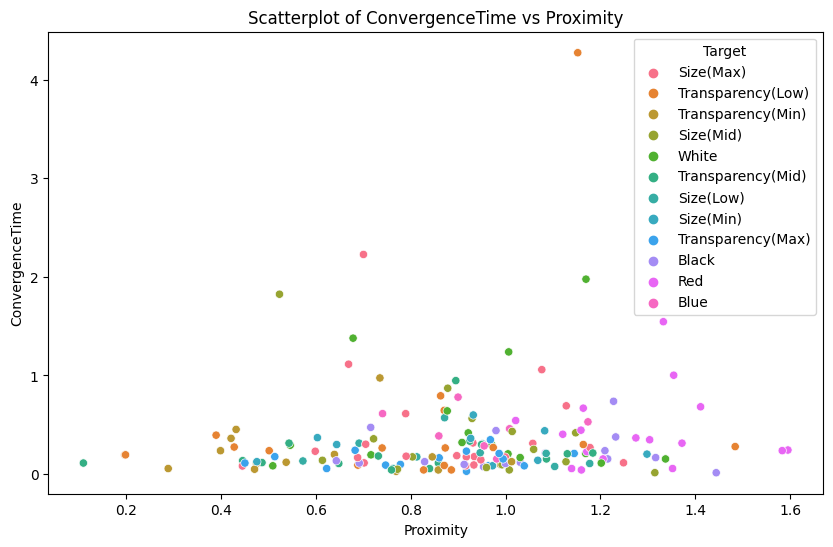

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over the list of dataframes
proxs = []
conv_times = []
targets = []

for df in dataframes:
    # Apply your ConvergTime and calculate_proximity functions
    conv_time_df = ConvergTime(df)
    prox_df = calculate_proximity(df)
    
    # Merge the results on the 'Target' column
    merged_df = pd.merge(conv_time_df, prox_df, on='Target')
    
    # Append the 'ConvergenceTime' and 'Proximity' columns to the lists
    conv_times.extend(merged_df['ConvergenceTime'].tolist())
    proxs.extend(merged_df['Proximity'].tolist())
    targets.extend(merged_df['Target'].tolist())

# Create a dataframe for the results
results_df = pd.DataFrame({'Proximity': proxs, 'ConvergenceTime': conv_times, 'Target': targets})

# Create scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Proximity', y='ConvergenceTime', hue='Target', data=results_df)
plt.title('Scatterplot of ConvergenceTime vs Proximity')
plt.xlabel('Proximity')
plt.ylabel('ConvergenceTime')
plt.show()


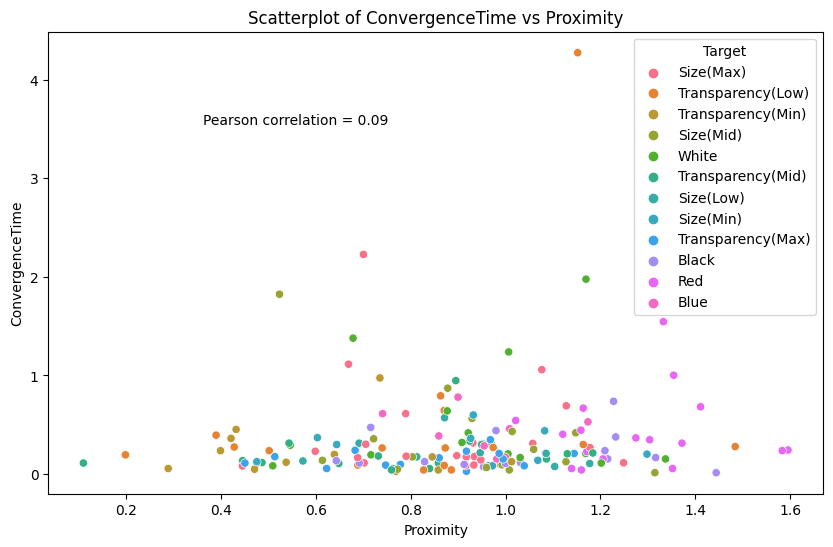

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Iterate over the list of dataframes
proxs = []
conv_times = []
targets = []

for df in dataframes:
    # Apply your ConvergTime and calculate_proximity functions
    conv_time_df = ConvergTime(df)
    prox_df = calculate_proximity(df)
    
    # Merge the results on the 'Target' column
    merged_df = pd.merge(conv_time_df, prox_df, on='Target')
    
    # Append the 'ConvergenceTime' and 'Proximity' columns to the lists
    conv_times.extend(merged_df['ConvergenceTime'].tolist())
    proxs.extend(merged_df['Proximity'].tolist())
    targets.extend(merged_df['Target'].tolist())

# Create a dataframe for the results
results_df = pd.DataFrame({'Proximity': proxs, 'ConvergenceTime': conv_times, 'Target': targets})

# Create scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Proximity', y='ConvergenceTime', hue='Target', data=results_df)

# Compute Pearson correlation
corr = pearsonr(results_df['Proximity'], results_df['ConvergenceTime'])[0]

# Display correlation on plot
plt.title('Scatterplot of ConvergenceTime vs Proximity')
plt.xlabel('Proximity')
plt.ylabel('ConvergenceTime')
plt.text(0.2, 0.8, f'Pearson correlation = {corr:.2f}', transform=plt.gca().transAxes)
plt.show()


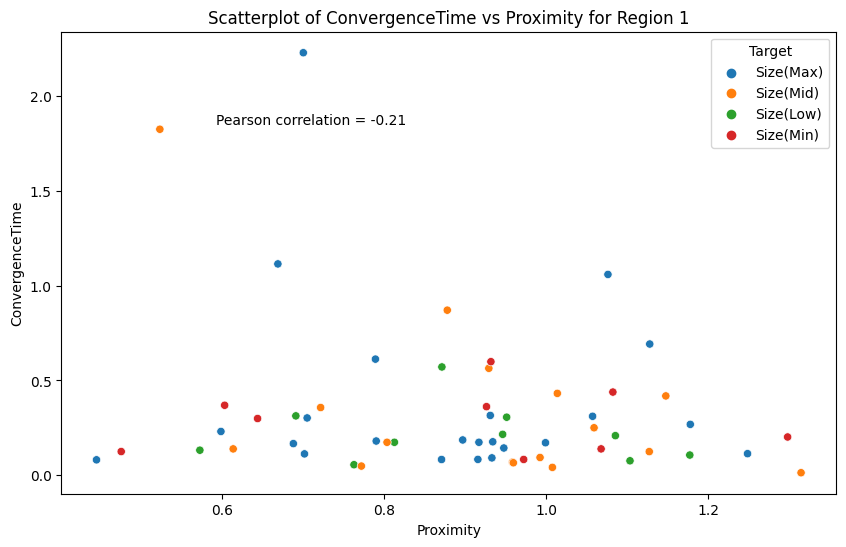

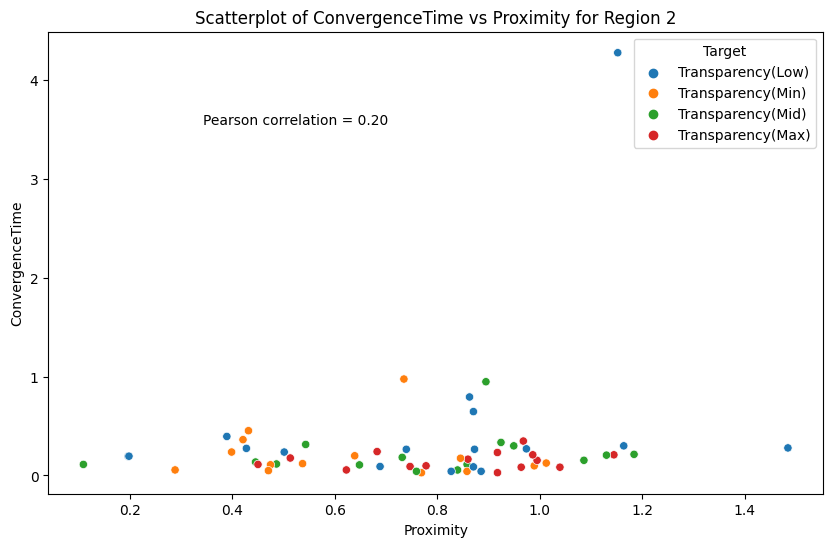

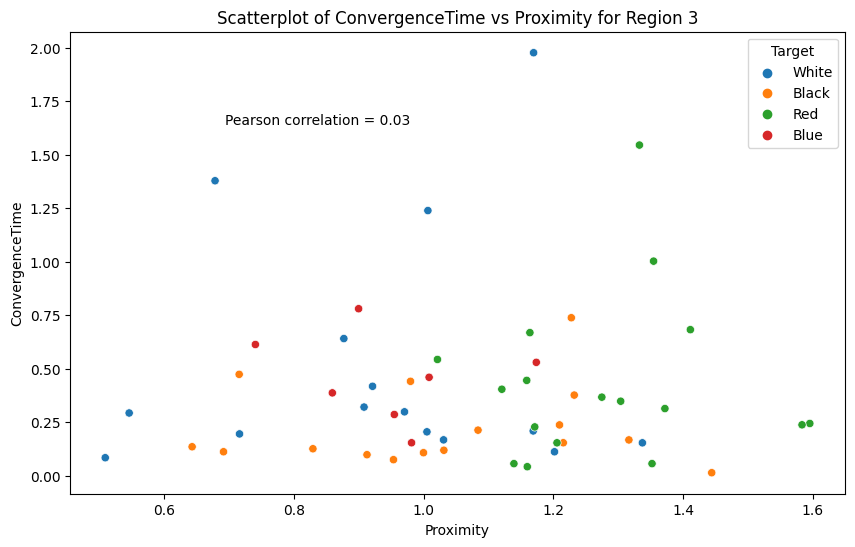

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define the number of regions
num_regions = 3

# Define a mapping from targets to regions (modify this according to your actual data)
target_region_mapping = {
    "Size(Low)": 1,
    "Size(Max)": 1,
    "Size(Mid)": 1,
    "Size(Min)": 1,
    "Transparency(Low)": 2,
    "Transparency(Max)": 2,
    "Transparency(Mid)": 2,
    "Transparency(Min)": 2,
    "Black": 3,
    "Blue": 3,
    "Red": 3,
    "White": 3
}

# Iterate over the list of dataframes
for region in range(1, num_regions+1):
    proxs = []
    conv_times = []
    targets = []

    for df in dataframes:
        # Apply your ConvergTime and calculate_proximity functions
        conv_time_df = ConvergTime(df)
        prox_df = calculate_proximity(df)
        
        # Filter for the current region
        conv_time_df = conv_time_df[conv_time_df['Target'].map(target_region_mapping) == region]
        prox_df = prox_df[prox_df['Target'].map(target_region_mapping) == region]

        # Merge the results on the 'Target' column
        merged_df = pd.merge(conv_time_df, prox_df, on='Target')
        
        # Append the 'ConvergenceTime' and 'Proximity' columns to the lists
        conv_times.extend(merged_df['ConvergenceTime'].tolist())
        proxs.extend(merged_df['Proximity'].tolist())
        targets.extend(merged_df['Target'].tolist())

    # Create a dataframe for the results
    results_df = pd.DataFrame({'Proximity': proxs, 'ConvergenceTime': conv_times, 'Target': targets})

    # Create scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Proximity', y='ConvergenceTime', hue='Target', data=results_df)

    # Compute Pearson correlation
    corr = pearsonr(results_df['Proximity'], results_df['ConvergenceTime'])[0]

    # Display correlation on plot
    plt.title(f'Scatterplot of ConvergenceTime vs Proximity for Region {region}')
    plt.xlabel('Proximity')
    plt.ylabel('ConvergenceTime')
    plt.text(0.2, 0.8, f'Pearson correlation = {corr:.2f}', transform=plt.gca().transAxes)
    plt.show()


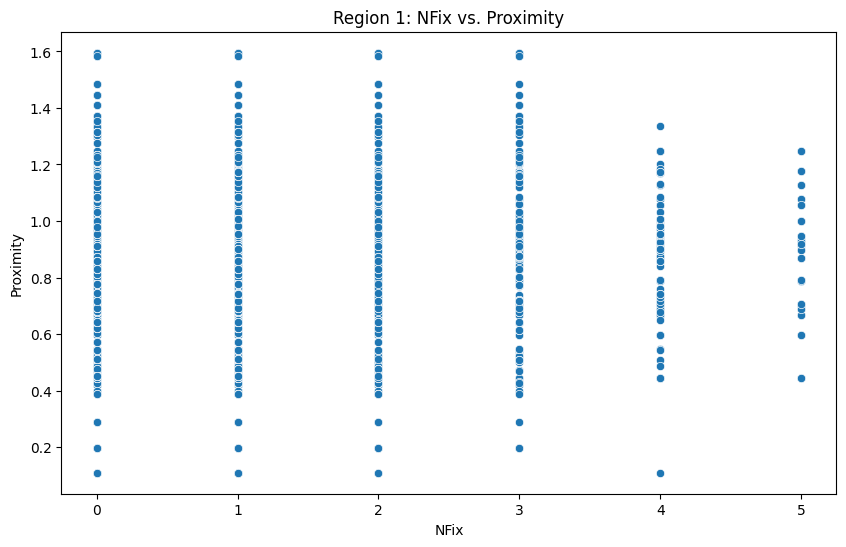

Region 1: Pearson correlation = 0.007430045561201775


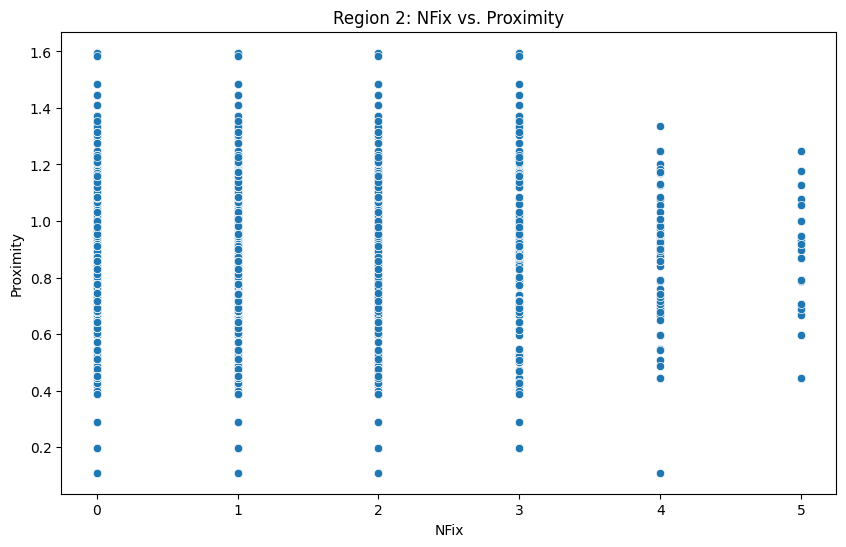

Region 2: Pearson correlation = 0.007430045561201775


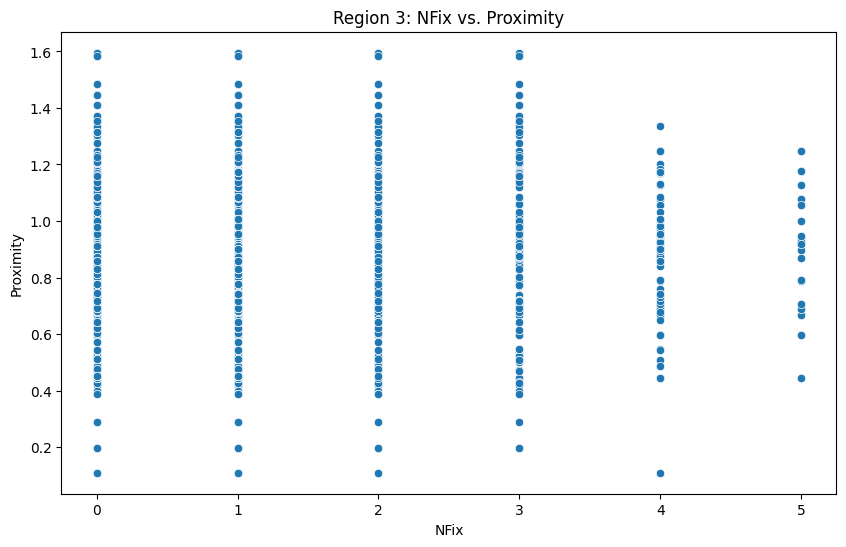

Region 3: Pearson correlation = 0.007430045561201775


In [217]:
# Set up your regions
regions = [1, 2, 3]

# Loop through each region
for region in regions:
    
    # Calculate NFix and Proximity for each dataframe and store results
    nfix_results = []
    prox_results = []
    for df in dataframes:
        nfix_df = NFix(df, 0.15, ShowPercentage = False)
        nfix_df['Region'] = region  # add the region information
        nfix_results.append(nfix_df)
        
        prox_df = calculate_proximity(df)
        prox_df['Region'] = region  # add the region information
        prox_results.append(prox_df)
        
    nfix_df = pd.concat(nfix_results)
    prox_df = pd.concat(prox_results)

    # Filter for the current region
    nfix_df = nfix_df[nfix_df['Region'] == region]
    prox_df = prox_df[prox_df['Region'] == region]
    
    # Merge the results on the 'Target' column
    merged_df = pd.merge(nfix_df, prox_df, on='Target')
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=merged_df, x='NFix', y='Proximity')
    plt.title(f'Region {region}: NFix vs. Proximity')
    plt.show()

    # Print the Pearson correlation
    correlation = merged_df[['NFix', 'Proximity']].corr().iloc[0, 1]
    print(f'Region {region}: Pearson correlation = {correlation}')


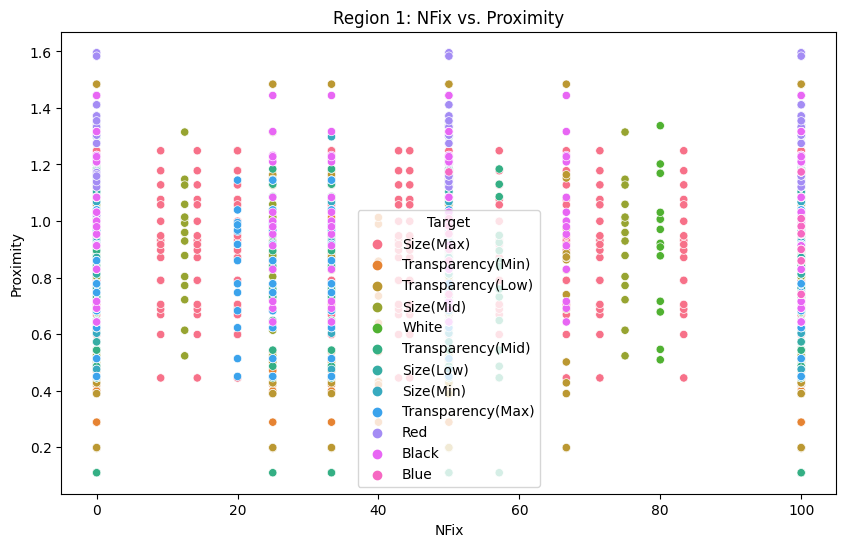

Region 1: Pearson correlation = 0.1069876474583196


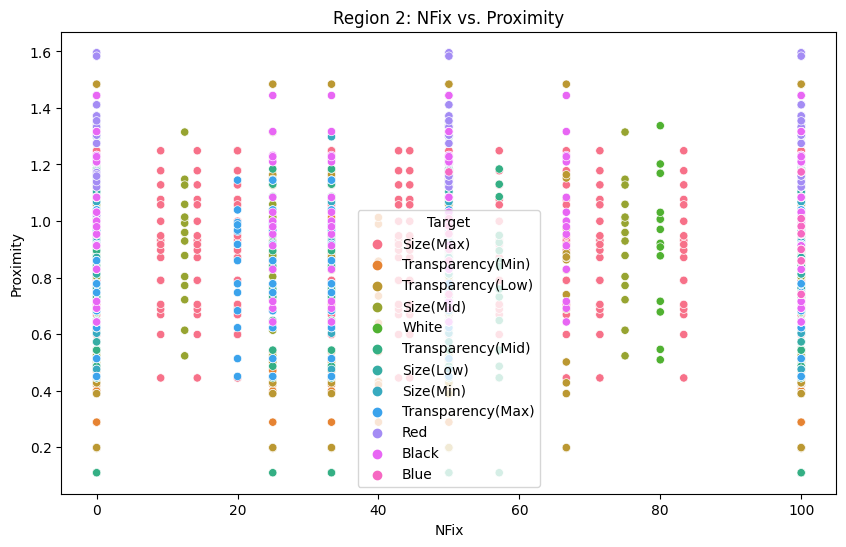

Region 2: Pearson correlation = 0.1069876474583196


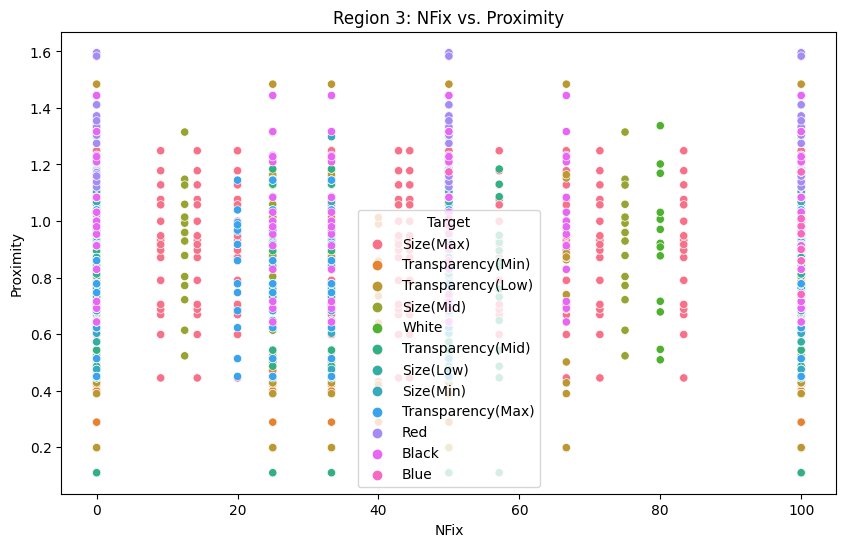

Region 3: Pearson correlation = 0.1069876474583196


In [218]:
# Set up your regions
regions = [1, 2, 3]

# Loop through each region
for region in regions:
    
    # Calculate NFix and Proximity for each dataframe and store results
    nfix_results = []
    prox_results = []
    for df in dataframes:
        nfix_df = NFix(df, 0.15, ShowPercentage = True)
        nfix_df['Region'] = region  # add the region information
        nfix_results.append(nfix_df)
        
        prox_df = calculate_proximity(df)
        prox_df['Region'] = region  # add the region information
        prox_results.append(prox_df)
        
    nfix_df = pd.concat(nfix_results)
    prox_df = pd.concat(prox_results)

    # Filter for the current region
    nfix_df = nfix_df[nfix_df['Region'] == region]
    prox_df = prox_df[prox_df['Region'] == region]
    
    # Merge the results on the 'Target' column
    merged_df = pd.merge(nfix_df, prox_df, on=['Target', 'Region'])
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=merged_df, x='NFix', y='Proximity', hue='Target')
    plt.title(f'Region {region}: NFix vs. Proximity')
    plt.show()

    # Print the Pearson correlation
    correlation = merged_df[['NFix', 'Proximity']].corr().iloc[0, 1]
    print(f'Region {region}: Pearson correlation = {correlation}')


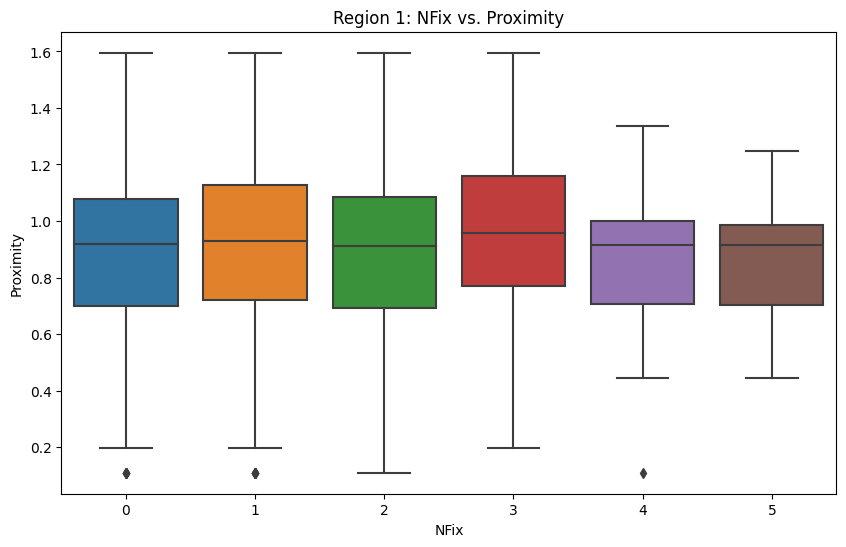

Region 1: Pearson correlation = 0.007430045561201775


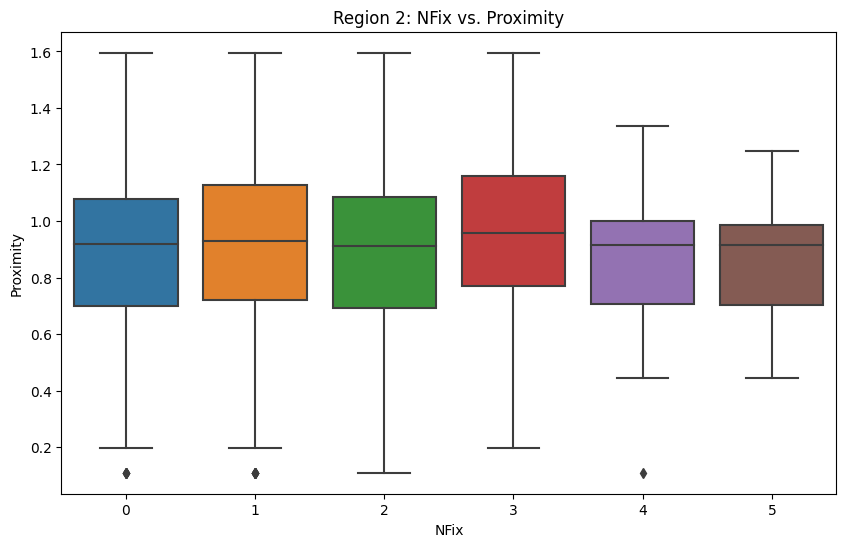

Region 2: Pearson correlation = 0.007430045561201775


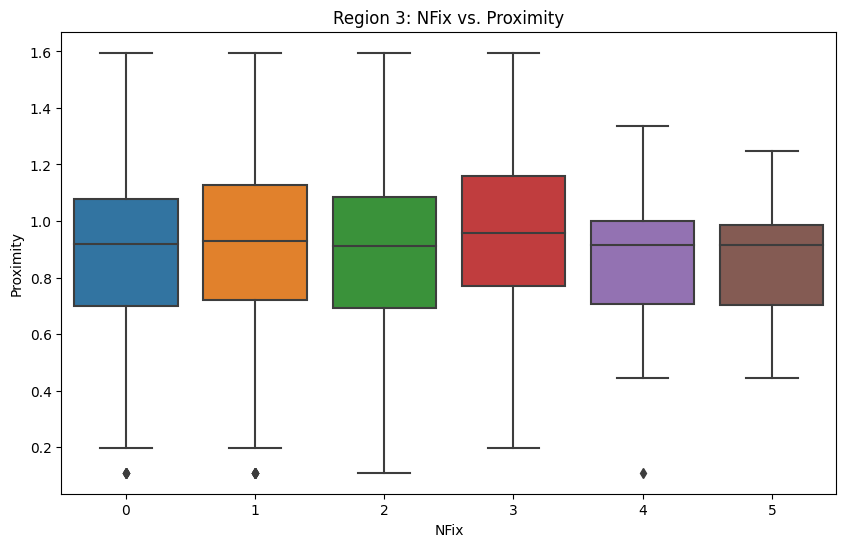

Region 3: Pearson correlation = 0.007430045561201775


In [219]:
# Set up your regions
regions = [1, 2, 3]

# Loop through each region
for region in regions:
    
    # Calculate NFix and Proximity for each dataframe and store results
    nfix_results = []
    prox_results = []
    for df in dataframes:
        nfix_df = NFix(df, 0.15, ShowPercentage = False)
        nfix_df['Region'] = region  # add the region information
        nfix_results.append(nfix_df)
        
        prox_df = calculate_proximity(df)
        prox_df['Region'] = region  # add the region information
        prox_results.append(prox_df)
        
        
        
    nfix_df = pd.concat(nfix_results)
    prox_df = pd.concat(prox_results)

    # Filter for the current region
    nfix_df = nfix_df[nfix_df['Region'] == region]
    prox_df = prox_df[prox_df['Region'] == region]
    
    # Merge the results on the 'Target' column
    merged_df = pd.merge(nfix_df, prox_df, on=['Target', 'Region'])
    
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_df, x='NFix', y='Proximity')
    plt.title(f'Region {region}: NFix vs. Proximity')
    plt.show()

    # Print the Pearson correlation
    correlation = merged_df[['NFix', 'Proximity']].corr().iloc[0, 1]
    print(f'Region {region}: Pearson correlation = {correlation}')


In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# List to store the results
nfix_results = []
prox_results = []

for df in dataframes:
    # Get the convergence time and proximity for each dataframe
    nfix_df = NFix(df, 0.15, ShowPercentage = False)
    prox_df = calculate_proximity(df)
    
    # Append the results to the list
    nfix_results.append(nfix_df)
    prox_results.append(prox_df)

# Concatenate all the dataframes in the result lists
nfix_df = pd.concat(nfix_results)
prox_df = pd.concat(prox_results)

# List of unique regions
regions = nfix_df['Region'].unique()

print(nfix_df.to_string())

    Region             Target  NFix
0        1          Size(Max)     4
1        1               None     0
2        2               None     5
3        2  Transparency(Min)     3
4        2  Transparency(Low)     1
5        3               None     0
0        1               None     2
1        1          Size(Max)     1
2        1          Size(Mid)     0
3        2               None     4
4        3              White     1
5        3               None     0
0        1               None     8
1        2  Transparency(Mid)     1
2        2               None     2
3        3               None     2
4        3              White     1
0        1               None     9
1        1          Size(Mid)     1
2        2               None     4
3        3               None     8
0        1          Size(Low)     1
1        1               None     0
2        1          Size(Min)     2
3        1          Size(Max)     1
4        1          Size(Mid)     0
5        2               Non

Region 3: Pearson correlation = 0.007430045561202118


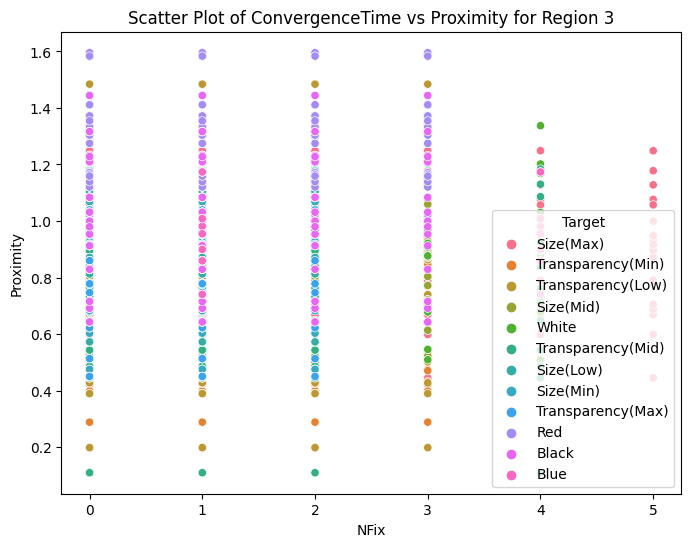

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

regions = merged_df['Region'].unique()

for region in regions:
    # Filter for the current region
    region_df = merged_df[merged_df['Region'] == region]
    
    # Calculate the Pearson correlation
    corr, _ = pearsonr(region_df['NFix'], region_df['Proximity'])
    print('Region {}: Pearson correlation = {}'.format(region, corr))

    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='NFix', y='Proximity', hue='Target', data=region_df)
    plt.title('Scatter Plot of ConvergenceTime vs Proximity for Region {}'.format(region))
    plt.show()
